In [1]:
from keras import layers
import keras
import keras.backend as K
from __future__ import absolute_import,print_function,division
import tensorflow as tf 
import tensorflow.keras as keras
import matplotlib.pyplot as plt 
import numpy as np 
import os
import PIL
import imageio
import glob
import time 

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
%matplotlib inline
from sklearn.utils import shuffle
import random

In [2]:
def readTrain():
  train = pd.read_csv("Driving Data test _3.csv")
  return train
def DriverA(data):
  dataA = data.iloc[0:7240,:]
  dataB = data.iloc[7241:20125,:]
  dataC = data.iloc[20126:27625,:]
  dataD = data.iloc[27626:40869,:]
  dataE = data.iloc[40870:49305,:]
  dataF = data.iloc[49306:60317,:]
  dataG = data.iloc[60318:67809,:]
  dataH = data.iloc[67810:77689,:]
  dataI = data.iloc[77690:85497,:]
  dataJ = data.iloc[85498:94401,:]
  return dataA,dataB,dataC,dataD,dataE,dataF,dataG,dataH,dataI,dataJ
def normalize(train):
  train = train.drop(["Class"], axis=1)
  train_norm = train.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
  return train_norm
def buildTrain(train, pastDay=60, futureDay=5):
  X_train, Y_train = [], []
  for i in range(train.shape[0]-16):
    X_train.append(np.array(train.iloc[i:i+16,0:16]))
    #Y_train.append(np.array(train.iloc[i:i+1]["Fuel_consumption"]))
  return np.array(X_train)
train = readTrain()
train_norm = normalize(train)

In [3]:
dataA,dataB,dataC,dataD,dataE,dataF,dataG,dataH,dataI,dataJ = DriverA(train_norm)

In [4]:
dataAA,dataBB,dataCC,dataDD,dataEE,dataFF,dataGG,dataHH,dataII,dataJJ = DriverA(train)

In [5]:
trainA = buildTrain(dataA)
trainA.shape

(7224, 16, 16)

In [6]:
trainB = buildTrain(dataB)
trainB = np.reshape(trainB,(12868,16,16,1))

In [7]:
trainA = np.reshape(trainA,(7224,16,16,1))

In [8]:
dataA_p = dataA.iloc[4000:5000,0:16]
trainA_part = buildTrain(dataA_p)
trainA_part = np.reshape(trainA_part,(984,16,16,1))

In [9]:
dataB_p = dataB.iloc[4000:5000,0:16]
trainB_part = buildTrain(dataB_p)
trainB_part = np.reshape(trainB_part,(984,16,16,1))

In [10]:
labelA = np.ones(984)
labelB = np.zeros(984)
labelAB = np.concatenate([labelA,labelB])

In [11]:
labelAB.shape

(1968,)

In [12]:
dataAB_p = np.vstack([trainA_part,trainB_part])

In [13]:
dataAB_p = np.reshape(dataAB_p,(1968,256))

In [14]:
index = [i for i in range(len(dataAB_p))]
random.shuffle(index)
dataAB_p = dataAB_p[index]
labelAB = labelAB[index]

In [15]:
dataAB_p_r = np.reshape(dataAB_p,(1968,16,16,1))

In [16]:
width = 16
height = 16
channels = 1

In [17]:
#load data
from keras.datasets import mnist
import cv2
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()
#x_ok = x_train[y_train == 1] # 6742 筆
x_test = x_test[(y_test == 7) | (y_test == 1)] # 1135 筆 "1", 1028 筆 "7"
y_test = y_test[(y_test == 7) | (y_test == 1)]

def reshape_x(x):
    new_x = np.empty((len(x), width, height))
    for i, e in enumerate(x):
        new_x[i] = cv2.resize(e, (width, height))
    return np.expand_dims(new_x, axis=-1) / 127 - 1
  
#x_ok = reshape_x(x_ok)
x_test = reshape_x(x_test)

In [18]:
#Generators Encoder
input_layer = layers.Input(name='input', shape=(height, width, channels))

# Encoder
x = layers.Conv2D(32, (5,5), strides=(1,1), padding='same', name='conv_1', kernel_regularizer = 'l2')(input_layer)
x = layers.LeakyReLU(name='leaky_1')(x)

x = layers.Conv2D(64, (3,3), strides=(2,2), padding='same', name='conv_2', kernel_regularizer = 'l2')(x)
x = layers.BatchNormalization(name='norm_1')(x)
x = layers.LeakyReLU(name='leaky_2')(x)


x = layers.Conv2D(128, (3,3), strides=(2,2), padding='same', name='conv_3', kernel_regularizer = 'l2')(x)
x = layers.BatchNormalization(name='norm_2')(x)
x = layers.LeakyReLU(name='leaky_3')(x)


x = layers.Conv2D(128, (3,3), strides=(2,2), padding='same', name='conv_4', kernel_regularizer = 'l2')(x)
x = layers.BatchNormalization(name='norm_3')(x)
x = layers.LeakyReLU(name='leaky_4')(x)

x = layers.GlobalAveragePooling2D(name='g_encoder_output')(x)

g_e = keras.models.Model(inputs=input_layer, outputs=x)

g_e.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 16, 16, 1)]       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 16, 16, 32)        832       
_________________________________________________________________
leaky_1 (LeakyReLU)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 8, 8, 64)          18496     
_________________________________________________________________
norm_1 (BatchNormalization)  (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_2 (LeakyReLU)          (None, 8, 8, 64)          0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 4, 4, 128)        

In [19]:
#Generator
input_layer = layers.Input(name='input', shape=(height, width, channels))

x = g_e(input_layer)

y = layers.Dense(width * width * 2, name='dense')(x) # 2 = 128 / 8 / 8
y = layers.Reshape((width//8, width//8, 128), name='de_reshape')(y)

y = layers.Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', name='deconv_1', kernel_regularizer = 'l2')(y)
y = layers.LeakyReLU(name='de_leaky_1')(y)

y = layers.Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', name='deconv_2', kernel_regularizer = 'l2')(y)
y = layers.LeakyReLU(name='de_leaky_2')(y)

y = layers.Conv2DTranspose(32, (3,3), strides=(2,2), padding='same', name='deconv_3', kernel_regularizer = 'l2')(y)
y = layers.LeakyReLU(name='de_leaky_3')(y)

y = layers.Conv2DTranspose(channels, (1, 1), strides=(1,1), padding='same', name='decoder_deconv_output', kernel_regularizer = 'l2', activation='tanh')(y)

g = keras.models.Model(inputs=input_layer, outputs=y)

g.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 16, 16, 1)]       0         
_________________________________________________________________
functional_1 (Functional)    (None, 128)               242048    
_________________________________________________________________
dense (Dense)                (None, 512)               66048     
_________________________________________________________________
de_reshape (Reshape)         (None, 2, 2, 128)         0         
_________________________________________________________________
deconv_1 (Conv2DTranspose)   (None, 4, 4, 128)         147584    
_________________________________________________________________
de_leaky_1 (LeakyReLU)       (None, 4, 4, 128)         0         
_________________________________________________________________
deconv_2 (Conv2DTranspose)   (None, 8, 8, 64)         

In [20]:
#Encoder
input_layer = layers.Input(name='input', shape=(height, width, channels))

z = layers.Conv2D(32, (5,5), strides=(1,1), padding='same', name='encoder_conv_1', kernel_regularizer = 'l2')(input_layer)
z = layers.LeakyReLU()(z)

z = layers.Conv2D(64, (3,3), strides=(2,2), padding='same', name='encoder_conv_2', kernel_regularizer = 'l2')(z)
z = layers.BatchNormalization(name='encoder_norm_1')(z)
z = layers.LeakyReLU()(z)


z = layers.Conv2D(128, (3,3), strides=(2,2), padding='same', name='encoder_conv_3', kernel_regularizer = 'l2')(z)
z = layers.BatchNormalization(name='encoder_norm_2')(z)
z = layers.LeakyReLU()(z)

z = layers.Conv2D(128, (3,3), strides=(2,2), padding='same', name='conv_41', kernel_regularizer = 'l2')(z)
z = layers.BatchNormalization(name='encoder_norm_3')(z)
z = layers.LeakyReLU()(z)

z = layers.GlobalAveragePooling2D(name='encoder_output')(z)

encoder = keras.models.Model(input_layer, z)
encoder.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 16, 16, 1)]       0         
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, 16, 16, 32)        832       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16, 16, 32)        0         
_________________________________________________________________
encoder_conv_2 (Conv2D)      (None, 8, 8, 64)          18496     
_________________________________________________________________
encoder_norm_1 (BatchNormali (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 64)          0         
_________________________________________________________________
encoder_conv_3 (Conv2D)      (None, 4, 4, 128)        

In [21]:
#feature extractor
input_layer = layers.Input(name='input', shape=(height, width, channels))

f = layers.Conv2D(32, (5,5), strides=(1,1), padding='same', name='f_conv_1', kernel_regularizer = 'l2')(input_layer)
f = layers.LeakyReLU(name='f_leaky_1')(f)

f = layers.Conv2D(64, (3,3), strides=(2,2), padding='same', name='f_conv_2', kernel_regularizer = 'l2')(f)
f = layers.BatchNormalization(name='f_norm_1')(f)
f = layers.LeakyReLU(name='f_leaky_2')(f)


f = layers.Conv2D(128, (3,3), strides=(2,2), padding='same', name='f_conv_3', kernel_regularizer = 'l2')(f)
f = layers.BatchNormalization(name='f_norm_2')(f)
f = layers.LeakyReLU(name='f_leaky_3')(f)


f = layers.Conv2D(128, (3,3), strides=(2,2), padding='same', name='f_conv_4', kernel_regularizer = 'l2')(f)
f = layers.BatchNormalization(name='f_norm_3')(f)
f = layers.LeakyReLU(name='feature_output')(f)

feature_extractor = keras.models.Model(input_layer, f)

feature_extractor.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 16, 16, 1)]       0         
_________________________________________________________________
f_conv_1 (Conv2D)            (None, 16, 16, 32)        832       
_________________________________________________________________
f_leaky_1 (LeakyReLU)        (None, 16, 16, 32)        0         
_________________________________________________________________
f_conv_2 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
f_norm_1 (BatchNormalization (None, 8, 8, 64)          256       
_________________________________________________________________
f_leaky_2 (LeakyReLU)        (None, 8, 8, 64)          0         
_________________________________________________________________
f_conv_3 (Conv2D)            (None, 4, 4, 128)        

In [22]:
#gan trainer
class AdvLoss(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AdvLoss, self).__init__(**kwargs)

    def call(self, x, mask=None):
        ori_feature = feature_extractor(x[0])
        gan_feature = feature_extractor(x[1])
        return K.mean(K.square(ori_feature - K.mean(gan_feature, axis=0)))

    def get_output_shape_for(self, input_shape):
        return (input_shape[0][0], 1)
    
class CntLoss(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(CntLoss, self).__init__(**kwargs)

    def call(self, x, mask=None):
        ori = x[0]
        gan = x[1]
        return K.mean(K.abs(ori - gan))

    def get_output_shape_for(self, input_shape):
        return (input_shape[0][0], 1)
    
class EncLoss(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(EncLoss, self).__init__(**kwargs)

    def call(self, x, mask=None):
        ori = x[0]
        gan = x[1]
        return K.mean(K.square(g_e(ori) - encoder(gan)))

    def get_output_shape_for(self, input_shape):
        return (input_shape[0][0], 1)
    
# model for training
input_layer = layers.Input(name='input', shape=(height, width, channels))
gan = g(input_layer) # g(x)

adv_loss = AdvLoss(name='adv_loss')([input_layer, gan])
cnt_loss = CntLoss(name='cnt_loss')([input_layer, gan])
enc_loss = EncLoss(name='enc_loss')([input_layer, gan])

gan_trainer = keras.models.Model(input_layer, [adv_loss, cnt_loss, enc_loss])

# loss function
def loss(yt, yp):
    return yp

losses = {
    'adv_loss': loss,
    'cnt_loss': loss,
    'enc_loss': loss,
}

lossWeights = {'cnt_loss': 20.0, 'adv_loss': 1.0, 'enc_loss': 1.0}

# compile
gan_trainer.compile(optimizer = 'adam', loss=losses, loss_weights=lossWeights)

In [23]:
gan_trainer.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 16, 16, 1)]  0                                            
__________________________________________________________________________________________________
functional_3 (Functional)       (None, 16, 16, 1)    547969      input[0][0]                      
__________________________________________________________________________________________________
adv_loss (AdvLoss)              ()                   0           input[0][0]                      
                                                                 functional_3[0][0]               
__________________________________________________________________________________________________
cnt_loss (CntLoss)              ()                   0           input[0][0]           

In [24]:
#discriminator

input_layer = layers.Input(name='input', shape=(height, width, channels))

f = feature_extractor(input_layer)

d = layers.GlobalAveragePooling2D(name='glb_avg')(f)
d = layers.Dense(1, activation='sigmoid', name='d_out')(d)
    
d = keras.models.Model(input_layer, d)
d.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 16, 16, 1)]       0         
_________________________________________________________________
functional_7 (Functional)    (None, 2, 2, 128)         242048    
_________________________________________________________________
glb_avg (GlobalAveragePoolin (None, 128)               0         
_________________________________________________________________
d_out (Dense)                (None, 1)                 129       
Total params: 242,177
Trainable params: 241,537
Non-trainable params: 640
_________________________________________________________________


In [25]:
d.compile(optimizer='adam', loss='binary_crossentropy')

In [26]:
trainA.max()

0.9625216261719473

In [27]:
#Training

niter = 20000
bz = 32
def get_data_generator(data, batch_size=32):
    datalen = len(data)
    cnt = 0
    while True:
        idxes = np.arange(datalen)
        np.random.shuffle(idxes)
        cnt += 1
        for i in range(int(np.ceil(datalen/batch_size))):
            train_x = np.take(data, idxes[i*batch_size: (i+1) * batch_size], axis=0)
            y = np.ones(len(train_x))
            yield train_x, [y, y, y]        

In [28]:
train_data_generator = get_data_generator(trainB, bz)

In [29]:
for i in range(niter):
    
    ### get batch x, y ###
    x, y = train_data_generator.__next__()
        
    ### train disciminator ###
    d.trainable = True
        
    fake_x = g.predict(x)
        
    d_x = np.concatenate([x, fake_x], axis=0)
    d_y = np.concatenate([np.zeros(len(x)), np.ones(len(fake_x))], axis=0)
        
    d_loss = d.train_on_batch(d_x, d_y)

    ### train generator ###
    
    d.trainable = False        
    g_loss = gan_trainer.train_on_batch(x, y)
    
    if i % 50 == 0:
        print(f'niter: {i+1}, g_loss: {g_loss}, d_loss: {d_loss}')

niter: 1, g_loss: [7.263525009155273, 3.271841706009582e-05, 0.09368482232093811, 0.22752688825130463], d_loss: 3.569434404373169
niter: 51, g_loss: [2.42020583152771, 1.3726573342864867e-05, 0.05542334169149399, 0.06754104048013687], d_loss: 0.9823530912399292
niter: 101, g_loss: [1.667868733406067, 1.2915104434796376e-06, 0.055071886628866196, 0.05427363142371178], d_loss: 0.3439534604549408
niter: 151, g_loss: [1.1970089673995972, 5.83242581342347e-06, 0.04141516983509064, 0.05043419450521469], d_loss: 0.13958203792572021
niter: 201, g_loss: [1.0485503673553467, 1.055750090017682e-06, 0.03751801326870918, 0.0483824647963047], d_loss: 0.06215715408325195
niter: 251, g_loss: [1.0232901573181152, 2.444993697281461e-06, 0.03775935620069504, 0.04672299325466156], d_loss: 0.029868293553590775
niter: 301, g_loss: [1.1694620847702026, 0.020263832062482834, 0.04455997049808502, 0.053028322756290436], d_loss: 0.14839614927768707
niter: 351, g_loss: [1.0244706869125366, 0.0298799816519022, 0.0

niter: 3101, g_loss: [2.0197269916534424, 0.8767387866973877, 0.04041166976094246, 0.04546591266989708], d_loss: 0.9516233801841736
niter: 3151, g_loss: [1.1712015867233276, 0.1632387787103653, 0.03788527101278305, 0.04243537783622742], d_loss: 0.5675590634346008
niter: 3201, g_loss: [0.8777341842651367, 0.05298347771167755, 0.03044833056628704, 0.037827204912900925], d_loss: 0.4060528576374054
niter: 3251, g_loss: [0.9952885508537292, 0.0686962753534317, 0.036063820123672485, 0.03778841719031334], d_loss: 0.24403412640094757
niter: 3301, g_loss: [0.8797949552536011, 0.04691483825445175, 0.03165644407272339, 0.04113326966762543], d_loss: 0.17805853486061096
niter: 3351, g_loss: [0.8537880182266235, 0.04219170659780502, 0.03110525757074356, 0.035320162773132324], d_loss: 0.1536817103624344
niter: 3401, g_loss: [1.1427067518234253, 0.05993733927607536, 0.044698573648929596, 0.04075957462191582], d_loss: 0.12980331480503082
niter: 3451, g_loss: [1.3982348442077637, 0.5204373598098755, 0.0

niter: 6201, g_loss: [2.4139480590820312, 0.11088580638170242, 0.06016005575656891, 0.07885301858186722], d_loss: 0.17482484877109528
niter: 6251, g_loss: [2.1784191131591797, 0.059301406145095825, 0.058130137622356415, 0.07314907014369965], d_loss: 0.12595142424106598
niter: 6301, g_loss: [1.7578623294830322, 0.06079163774847984, 0.042609915137290955, 0.07009761035442352], d_loss: 0.10162915289402008
niter: 6351, g_loss: [2.3995280265808105, 0.4837139844894409, 0.05750224366784096, 0.07638878375291824], d_loss: 0.17605718970298767
niter: 6401, g_loss: [1.5499449968338013, 0.06467346847057343, 0.03982328623533249, 0.0653345063328743], d_loss: 0.10483933240175247
niter: 6451, g_loss: [1.779524326324463, 0.2536490559577942, 0.044849611818790436, 0.06419364362955093], d_loss: 0.29974302649497986
niter: 6501, g_loss: [1.7214348316192627, 0.2160356193780899, 0.04632999747991562, 0.058841876685619354], d_loss: 0.24588492512702942
niter: 6551, g_loss: [1.482578992843628, 0.1692555993795395, 0

niter: 9301, g_loss: [0.9691296815872192, 0.01891288161277771, 0.03629441186785698, 0.04594575986266136], d_loss: 0.07336759567260742
niter: 9351, g_loss: [1.009366750717163, 0.04025690630078316, 0.03773943707346916, 0.04370155185461044], d_loss: 0.05329078808426857
niter: 9401, g_loss: [1.2143675088882446, 0.20436647534370422, 0.03951361030340195, 0.043733514845371246], d_loss: 0.12773539125919342
niter: 9451, g_loss: [38.827022552490234, 36.352813720703125, 0.0925976037979126, 0.12074935436248779], d_loss: 0.5696513652801514
niter: 9501, g_loss: [2.420362710952759, 0.3912614583969116, 0.06932172924280167, 0.07008683681488037], d_loss: 0.9009532332420349
niter: 9551, g_loss: [1.5230125188827515, 0.07572102546691895, 0.04928513616323471, 0.058886125683784485], d_loss: 0.358889639377594
niter: 9601, g_loss: [1.1963509321212769, 0.012864485383033752, 0.04124687612056732, 0.044870465993881226], d_loss: 0.2010284811258316
niter: 9651, g_loss: [1.355939269065857, 0.007053623907268047, 0.052

niter: 12401, g_loss: [1.8718106746673584, 0.05764338746666908, 0.07418709993362427, 0.07601084560155869], d_loss: 0.16196896135807037
niter: 12451, g_loss: [1.372761845588684, 0.048384107649326324, 0.050962936133146286, 0.06174292415380478], d_loss: 0.14550817012786865
niter: 12501, g_loss: [1.2462726831436157, 0.01930486038327217, 0.04653816670179367, 0.05882418155670166], d_loss: 0.11609905958175659
niter: 12551, g_loss: [3.4393105506896973, 2.2033283710479736, 0.048236917704343796, 0.051402147859334946], d_loss: 0.43175339698791504
niter: 12601, g_loss: [3.1243724822998047, 1.7024143934249878, 0.054615914821624756, 0.07045726478099823], d_loss: 1.0016348361968994
niter: 12651, g_loss: [1.1783943176269531, 0.09325656294822693, 0.04002147912979126, 0.05407697334885597], d_loss: 0.3932895362377167
niter: 12701, g_loss: [1.1700533628463745, 0.057084210216999054, 0.04337874799966812, 0.04351188242435455], d_loss: 0.20994623005390167
niter: 12751, g_loss: [0.9818583130836487, 0.036500796

niter: 15451, g_loss: [0.9189159870147705, 0.010203922167420387, 0.03340235352516174, 0.03748510777950287], d_loss: 0.11150958389043808
niter: 15501, g_loss: [0.9549574851989746, 0.010307572782039642, 0.035700343549251556, 0.04179080203175545], d_loss: 0.08957415819168091
niter: 15551, g_loss: [1.0478992462158203, 0.008215745911002159, 0.04098791256546974, 0.04480746388435364], d_loss: 0.19020842015743256
niter: 15601, g_loss: [0.9948033094406128, 0.11659502983093262, 0.03340717405080795, 0.03678203374147415], d_loss: 0.1749354600906372
niter: 15651, g_loss: [1.1823554039001465, 0.28863561153411865, 0.0339464396238327, 0.04382895305752754], d_loss: 0.30615511536598206
niter: 15701, g_loss: [1.5646506547927856, 0.43010708689689636, 0.0454009473323822, 0.047331035137176514], d_loss: 0.20612116158008575
niter: 15751, g_loss: [4.335566997528076, 3.026726245880127, 0.0510457307100296, 0.056328970938920975], d_loss: 0.5868594646453857
niter: 15801, g_loss: [1.4720897674560547, 0.316017299890

niter: 18501, g_loss: [3.414661169052124, 0.03952164947986603, 0.08777976781129837, 0.08870410174131393], d_loss: 0.29636654257774353
niter: 18551, g_loss: [3.248584508895874, 0.013564866967499256, 0.08733582496643066, 0.07844294607639313], d_loss: 0.1956167072057724
niter: 18601, g_loss: [2.8729374408721924, 0.009427589364349842, 0.07429510354995728, 0.07075092941522598], d_loss: 0.14637844264507294
niter: 18651, g_loss: [2.9748950004577637, 0.009511910378932953, 0.08315005898475647, 0.08461827039718628], d_loss: 0.11570523679256439
niter: 18701, g_loss: [2.700169324874878, 0.05223878100514412, 0.07150180637836456, 0.07767003029584885], d_loss: 0.10795307904481888
niter: 18751, g_loss: [3.5513908863067627, 1.054714560508728, 0.06764720380306244, 0.07575178146362305], d_loss: 0.20325574278831482
niter: 18801, g_loss: [2.656456708908081, 0.09973812103271484, 0.0733688622713089, 0.08281949162483215], d_loss: 0.11019542813301086
niter: 18851, g_loss: [2.346540689468384, 0.0307728014886379

In [30]:
#Evaluation
encoded = g_e.predict(dataAB_p_r)
gan_x = g.predict(dataAB_p_r)
encoded_gan = g_e.predict(gan_x)
score = np.sum(np.absolute(encoded - encoded_gan), axis=-1)
score = (score - np.min(score)) / (np.max(score) - np.min(score)) # map to 0~1
score_simple = np.sum(score,axis = 0)
score_simple=score_simple/len(score)

In [31]:
score_simple

0.1795628865559896

In [32]:
score

array([0.08855354, 0.06516114, 0.35208654, ..., 0.18425399, 0.06397457,
       0.0483288 ], dtype=float32)

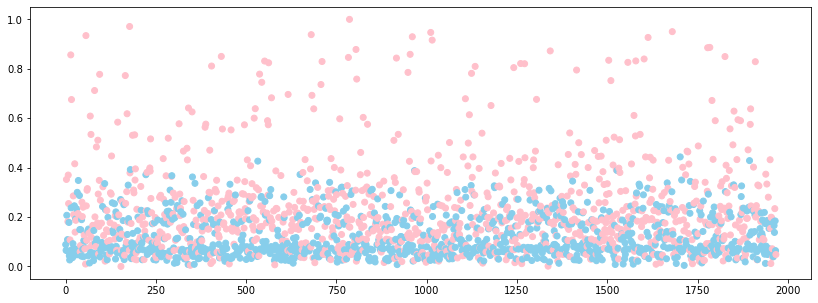

In [33]:
from matplotlib import pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5
plt.scatter(range(len(dataAB_p)),score, c=['skyblue' if x == 0 else 'pink' for x in labelAB])

In [34]:
y_test.shape

(2163,)

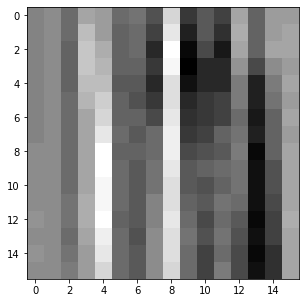

In [35]:
i = 4 # or 1
image = np.reshape(gan_x[i:i+1], (16, 16))
image = image * 127 + 127
plt.imshow(image.astype(np.uint8), cmap='gray')

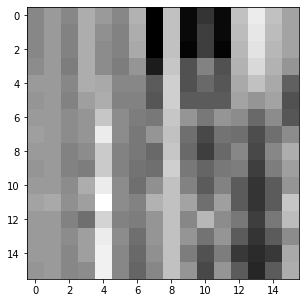

In [38]:

image = np.reshape(dataAB_p_r[i:i+1], (16, 16))
image = image * 127 + 127
plt.imshow(image.astype(np.uint8), cmap='gray')